In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#Import spectral libraries

In [3]:
from spectral.io import envi

# Ice
fili = "C:/Users/apbarret/Documents/data/Sheba2/Sheba.SpectralLibrary.ice.filled.hdr"
ice = envi.open(fili)

# Ponds
fili = "C:/Users/apbarret/Documents/data/Sheba2/Sheba.SpectralLibrary.pond.filled.hdr"
pond = envi.open(fili)

# Leads
fili = "C:/Users/apbarret/Documents/data/Sheba2/Sheba.SpectralLibrary.lead.filled.hdr"
lead = envi.open(fili)


#Import MODIS spectral response functions

In [4]:
from seaice_albedo_utilities import modis_srf, modis_bbalbedo
wv, srf = modis_srf()

Convert spectral albedos into modis broad band albedos and put into a pandas data frame

In [5]:
from seaice_albedo_utilities import spectra2modis
ice_df = spectra2modis(ice, wv, srf, code='I')
pond_df = spectra2modis(pond, wv, srf, code='P')
lead_df = spectra2modis(lead, wv, srf, code='L')

nice = ice_df['code'].count()
npond = pond_df['code'].count()
nlead = lead_df['code'].count()

Randomly select ice, pond and lead spectra

In [6]:
import pandas
import numpy.random as rnd
ii = rnd.random_integers(0,nice-1)
ip = rnd.random_integers(0,npond-1)
il = rnd.random_integers(0,nlead-1)
print ii, ip, il

0 5 8


Randomly get ice, pond and lead fractions

In [7]:
def get_surface_fraction(nsurf=3):

    import numpy.random as rnd
    
    frac = rnd.random(size=nsurf)
    frac = frac / frac.sum()
    
    return frac

In [11]:
def spectral_mixture_solver(ice, pond, lead, b):
    
    """
    USAGE: a, resid, rmse, isrange, isrmse, isresid = spectral_mixture_solver(ice, pond, lead, target)
    
    where 
    ice, pond, and lead: are n-element vectors with band reflectances
    target: vector containing band reflectances of target
    
    Returns:
        a - area fraction weights
        resid - vector of residuals
        rmse - scalar of root mean squared error
        isrange - boolean showing elements of a are within acceptable range [-0.01, 1.01]
        isrmse - boolean showing rmse is < 2.5% (0.025)
        isresid - boolean showing no three consecutive residuals are > 2.5% (0.025)
        
    Description:
        Algorithm is based on Painter's MODSCAG algorithm
        
    """
    
    # Put spectra into matrix
    A =np.vstack((np.hstack((ice,1)), 
                  np.hstack((pond,1)), 
                  np.hstack((lead,1)))).T
    ba = np.hstack((b,1))
    
    # Solve matrix - uses Gram-Schmidt QR
    m = np.linalg.lstsq(A, ba)[0]
    
    # Calculate estimates
    yhat = np.dot(A,m)
    
    # Calculate residual
    resid = ba - yhat
    
    # calculate rmse
    rmse = np.linalg.norm(resid)*0.5 # RMSE is half the frobius norm
    
    return (m, resid, rmse)

[ 0.13765145  0.25840962  0.60393912]
[ 0.16484954  0.35697148  0.47817898]


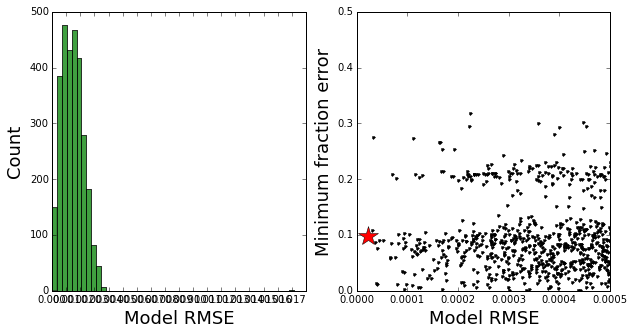

In [61]:
# Get random combination of area fractions
fsurf = get_surface_fraction(nsurf=3)
surface = np.array([ice_df['band1'][ii]*fsurf[0] + pond_df['band1'][ip]*fsurf[1] + lead_df['band1'][il]*fsurf[2] + np.random.normal(0.,0.001,1),
                    ice_df['band2'][ii]*fsurf[0] + pond_df['band2'][ip]*fsurf[1] + lead_df['band2'][il]*fsurf[2] + np.random.normal(0.,0.001,1),
                    ice_df['band3'][ii]*fsurf[0] + pond_df['band3'][ip]*fsurf[1] + lead_df['band3'][il]*fsurf[2] + np.random.normal(0.,0.001,1),
                    ice_df['band4'][ii]*fsurf[0] + pond_df['band4'][ip]*fsurf[1] + lead_df['band4'][il]*fsurf[2] + np.random.normal(0.,0.001,1)]).flatten()

# Find best three surface solution
area_frac = []
rmse_list = []
for iceid in np.arange(0,nice):
    for pndid in np.arange(0,npond):
        for ledid in np.arange(0,nlead):
            
            a, resid, rmse = spectral_mixture_solver(ice_df[['band1','band2','band3','band4']].loc[iceid].values,
                                                 pond_df[['band1','band2','band3','band4']].loc[pndid].values,
                                                 lead_df[['band1','band2','band3','band4']].loc[ledid].values,
                                                 surface)
    
            isrange = np.all((a > -0.01) & (a < 1.01))
            isresid = np.all((resid[0:3] < 0.025) & (resid[1:4] < 0.025) & (resid[2:] < 0.025))
            isrmse = rmse < 0.025
            isvalid = np.all((isrange,isresid,isrmse))
        
            if (isvalid):
                area_frac.append(a)
                rmse_list.append(rmse)
            

# Find best model
best_model = np.argmin(np.array(rmse_list))
print area_frac[best_model]
print fsurf

# Calculate error metric.  I use minimum difference because the area fractions are linked
min_error = []
for fest in area_frac:
    min_error.append((fsurf - fest).max())

# Plot results
import matplotlib.pyplot as plt

# rmse_max
rxmax = np.around(np.max(rmse_list),3)

f, ax = plt.subplots(1,2, figsize=(10,5))

n, bins, patches = ax[0].hist(rmse_list, 50, normed=1, facecolor='green', alpha=0.75)
start, end = ax[0].get_xlim()
#step = (end-start)/5.
ax[0].xaxis.set_ticks(np.arange(start, end, 0.001))
ax[0].set_xlabel('Model RMSE', fontsize=18)
ax[0].set_ylabel('Count', fontsize=18)

ax[1].plot(rmse_list, min_error, '.k')
ax[1].set_xlim(0.,0.0005)
ax[1].set_xlabel('Model RMSE', fontsize=18)
ax[1].set_ylabel('Minimum fraction error', fontsize=18)
ax[1].plot(rmse_list[np.argmin(np.array(rmse_list))],
         min_error[np.argmin(np.array(rmse_list))],'*r',markersize=20)

1) Calculate the rmse of area fractions for one run.  How many "good" estimates are there?
2) Then do 1000 reps 

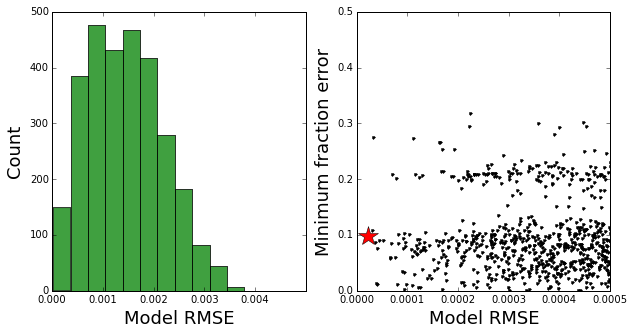

In [67]:
# Plot results
import matplotlib.pyplot as plt

# rmse_max
rxmax = np.around(np.max(rmse_list),3)

f, ax = plt.subplots(1,2, figsize=(10,5))

n, bins, patches = ax[0].hist(rmse_list, 50, normed=1, facecolor='green', alpha=0.75)
#start, end = ax[0].get_xlim()
#step = (end-start)/5.
ax[0].set_xlim(0.,0.005)
ax[0].xaxis.set_ticks(np.arange(0.0, 0.005, 0.001))
ax[0].set_xlabel('Model RMSE', fontsize=18)
ax[0].set_ylabel('Count', fontsize=18)

ax[1].plot(rmse_list, min_error, '.k')
ax[1].set_xlim(0.,0.0005)
ax[1].set_xlabel('Model RMSE', fontsize=18)
ax[1].set_ylabel('Minimum fraction error', fontsize=18)
ax[1].plot(rmse_list[np.argmin(np.array(rmse_list))],
         min_error[np.argmin(np.array(rmse_list))],'*r',markersize=20)
   
f.savefig('C:/Users/apbarret/Documents/Posters/AGU_Fall_2016_Barrett_Stroeve/uncertainty_for_agu2016.png')